<a href="https://colab.research.google.com/github/mariamhergnyan/Molecular_Simulations_exam/blob/main/Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these before working.

In [1]:
!pip install notebook==6.5.5  > /dev/null

In [2]:
!pip install ipywidgets > /dev/null

In [3]:
!pip install pyemma > /dev/null
!pip install mdshare > /dev/null
#!pip install MDAnalysis > dev/null
#4 minutes

In [4]:
!pip install nglview > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 7.1.0 which is incompatible.


In [5]:
!pip install biopython > /dev/null

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [108]:
%matplotlib inline
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
from scipy import interpolate
# for visualization of molecular structures:
import nglview
import mdtraj as md
from threading import Timer
from nglview.player import TrajectoryPlayer
from Bio.PDB import PDBParser
import pyemma.util.contexts as contexts
#import MDAnalysis as mda
import filecmp
from IPython.display import display
from threading import Timer
from google.colab import widgets
import ipywidgets
import warnings
from google.colab import files
import zipfile


# Suppress all warnings
warnings.filterwarnings("ignore")

In [8]:
#to deal with numpy's different versions
np.bool = np.bool_
np.float = np.float_

In [9]:
pdb = '/content/lb6-filtered.pdb'

In [10]:

# # Load the PDB and trajectory files
# u = md.load(pdb_file)
# traj = md.load(traj_file, top=pdb_file)


# # Specify the frame step size
# frame_step = 252

# # Directory where the output files will be located
# output_dir = 'output_files/'

# # Create the directory if it doesn't exist
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Iterate over trajectory frames with the specified frame step
# for i in range(0, len(traj), frame_step):
#     # Write XTC files for each frame
#     output_file_name = output_dir + 'output_{:06d}.xtc'.format(i)
#     md.Trajectory(traj.xyz[i], u.topology).save(output_file_name)

# # Create a zip file containing all output files
# zip_file_name = 'output.zip'
# with zipfile.ZipFile(zip_file_name, 'w') as zipf:
#     for filename in os.listdir(output_dir):
#         zipf.write(os.path.join(output_dir, filename), filename)

# # Download the zip file to the local machine
# files.download(zip_file_name)



In [11]:
traj_path = '/content/traj_files'

files_and_dirs = os.listdir(traj_path)

#Remove the checkpoint directory if it exists
for item in files_and_dirs:
    if item == '.ipynb_checkpoints':
        checkpoint_path = os.path.join(traj_path, item)
        shutil.rmtree(checkpoint_path)

files = os.listdir(traj_path)
#final paths to the files
files = [os.path.join(traj_path, file) for file in os.listdir(traj_path)]

#Feature selection
Since we don't know which features describe the best the molecule, we do feature selecting with VAMP(Variational Approach for Markov Proceess). We utilize the VAMP2 score which shows the kinetic variance. The minimum VAMP2 score is 1. The higher the score, the better the given feature describes the molecule. Here we only do the selection based on the features of the backbone and not the side chains.

In [12]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

Obtaining file info:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/5 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/5 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
#compute a cross validated vamp 2 score
    # we temporarily suppress very short-lived progress bars
    with contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

def find_max_vamp_score(data_sets, labels, dims, lags):
    max_score = -float('inf')
    best_property = None
    best_lag = None

    for property_data, property_label in zip(data_sets, labels):
        for lag in lags:
            scores = score_cv(property_data, lag=lag, dim=dims[property_label])
            mean_score = scores.mean()
            if mean_score > max_score:
                max_score = mean_score
                best_property = property_label
                best_lag = lag

    return best_property, best_lag, max_score

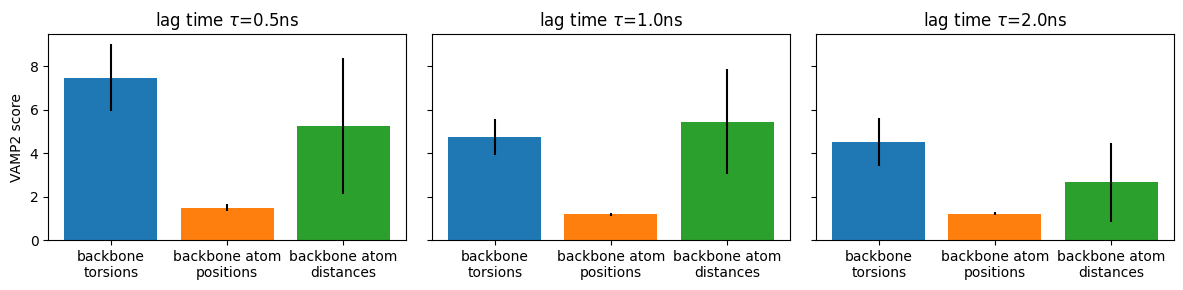

In [ ]:
dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

Trying with different lag times and dimensions

In [ ]:
dims = {'backbone torsions': 10, 'backbone atom positions': 10, 'backbone atom distances': 10}
labels_prime = ['backbone torsions', 'backbone atom positions', 'backbone atom distances']
lags = [2,5,7]
best_property, best_lag, max_score = find_max_vamp_score(
    [torsions_data, positions_data, distances_data],
    labels_prime,
    dims,
    lags
)

print("Property that descrbes the data best:", best_property)
print("Lag time of the highest score:", best_lag)
print("Highest VAMP2 score:", max_score)

# Determine the dataset based on the best property label
if best_property == 'backbone torsions':
  data = torsions_data
elif best_property == 'backbone atom positions':
  data = positions_data
elif best_property == 'backbone atom distances':
  data = distances_data
else:
  raise ValueError("Unknown property label: {}".format(best_property))


Property that descrbes the data best: backbone torsions
Lag time of the highest score: 2
Highest VAMP2 score: 8.815601496036956


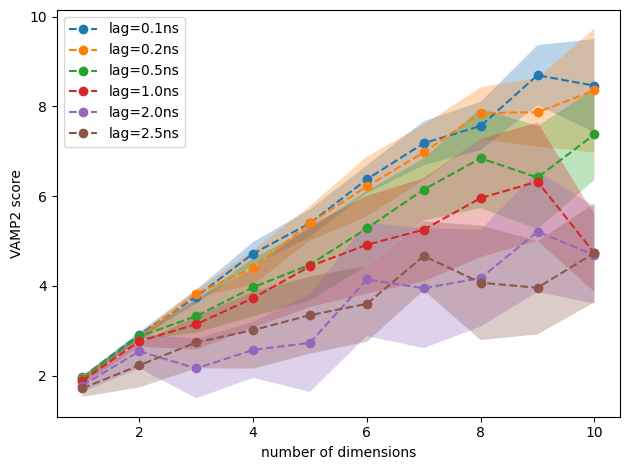

In [ ]:
lags = [1,2,5,10,20,25]
#dims = [1]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = []
    for dim in dims:
      #uncomment for debugging
        #print("Computing VAMP score for dim={}, lag={}".format(dim, lag))
        score = score_cv(data, dim, lag)
        scores_.append(score)
    scores_ = np.array(scores_)

    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()


In [13]:
#to make my life easier for working with colab
best_lag = 1
data =torsions_data

In [14]:
tica = pyemma.coordinates.tica(data, lag=best_lag, dim =10)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)


calculate covariances:   0%|          | 0/5 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
num_components = tica_concatenated.shape[1]
print("Number of components:", num_components)
#check how many independent components from TICA I have obtained
#the density plot shows the shape of the data

Number of components: 10


For torsion angles specifically, IC1 and IC2 would represent linear combinations of torsion angle features that best capture the dominant motions or conformational changes in the molecular system over time. These components may correspond to important collective motions, transitions between different states, or other dynamic behaviors exhibited by the molecular system.

IC1: The first independent component usually captures the slowest process or conformational change in the system. It represents the dominant mode of variation in the input torsion angles.

IC2: The second independent component captures the next slowest process or variation orthogonal to IC1. It represents a secondary mode of motion that is independent of IC1.

Specifically, in this case the ICs represent linear combinations of the original torsion angle features that maximize the variance or capture the most significant correlations in the data while considering the time-lagged dependencies. Therefore, these components provide insight into the dominant patterns of motion or conformational changes exhibited by the molecular system over the course of the simulation.

The distinct regions or clusters in the density plot correspond to different conformational states or basins in the conformational space.
Transitions between states may be represented by regions of lower density or transition regions where densities between different states overlap.

The projection yields defined clusters of high density, which are most likely to be identified as metastable basins.

Todo: try with both log and non log scales.


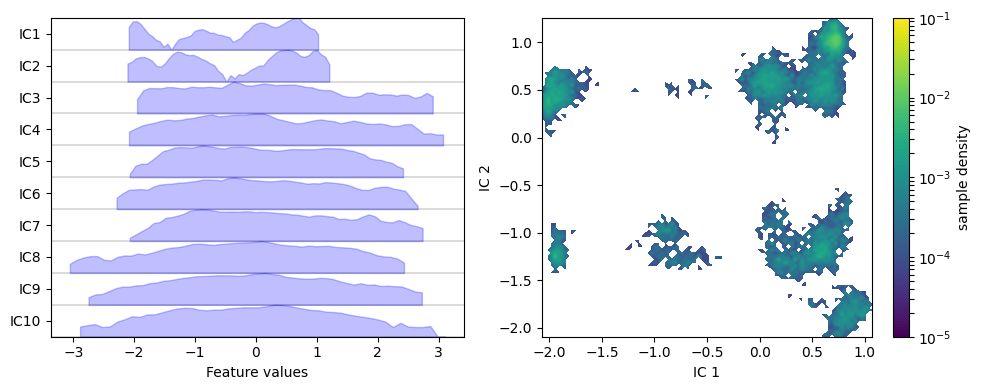

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Determine the number of independent components (ICs)
num_ic = tica_concatenated.shape[1]

# Generate feature labels for the independent components (ICs)
feature_labels = ['IC{}'.format(i + 1) for i in range(num_ic)]

# Plot the feature histograms with the adjusted feature labels
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=feature_labels,
    ylog=True
)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True) #try without the log scale
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

Each subplot represents the time evolution of one independent component (IC) extracted from the TICA analysis.
The x-axis represents time, and the y-axis represents the magnitude or amplitude of the IC.
By visualizing the time series of each IC, you can identify patterns, fluctuations, and dynamics in the data captured by the TICA transformation.
Peaks, troughs, or patterns in the IC time series may correspond to significant conformational changes, transitions, or dynamics in the molecular system.

Todo: check how many ICs are being created here and if they correspond to all the ones that we have.

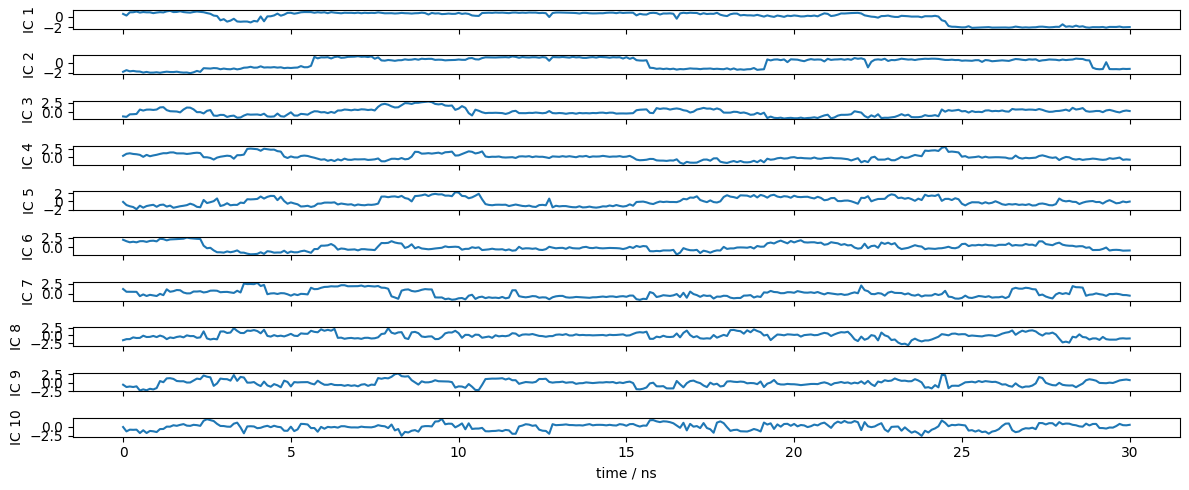

In [ ]:
fig, axes = plt.subplots(tica_output[0].shape[1], 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])

for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))

axes[-1].set_xlabel('time / ns')
fig.tight_layout()


###Discretization
The TICA coordinates now will be put into k discrete states.We have to find at how many states is the VAMP score saturated.
We will set the MSM lag time to TICA lag time.
Besides having an optimal score, we want to obtain a model that describes physically interesting states. Thus, the number of states k
 is often re-adjusted after model inspection.



14-02-24 16:08:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3993] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[3997] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4001] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4005] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4009] WARNING  Requested scoring rank 5 exceeds number of MSM states. Reduced to score_k = 3


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4013] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4017] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4021] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:53 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4025] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


14-02-24 16:08:54 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[4029] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 7


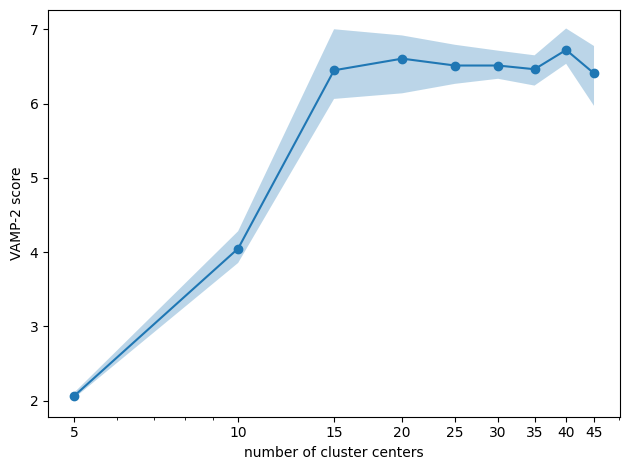

In [133]:
n_clustercenters = [5, 10, 15,20,25,30, 35,40,45]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50,fixed_seed = 1)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
ax.set_xticks(n_clustercenters)
ax.set_xticklabels(n_clustercenters)
fig.tight_layout()

The VAMP-2 score doesn't saturate much after 20 clusters. But for the best result have fixed the random seed and for the density plot we will use the amount of clusters with the highest VAMP-2 score.

In [66]:
#again to make my life with colab easier
k = 45
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=k, max_iter=100, stride=50, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|          | 0/45 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/5 [00:00<?, ?it/s]

In [67]:
np.shape(dtrajs_concatenated)

(2598,)

initialize kmeans++ centers:   0%|          | 0/40 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/5 [00:00<?, ?it/s]

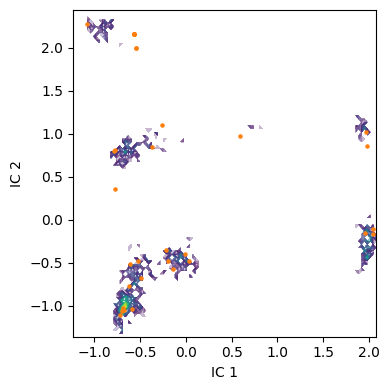

In [135]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

We obtain 6 big clusters. Since the kmeans algorithm is stochastic, results may vary from run to run. The random seed is fixed for this purpose.

estimating BayesianMSM:   0%|          | 0/11 [00:00<?, ?it/s]

<Axes: xlabel='lag time / ps', ylabel='timescale / ps'>

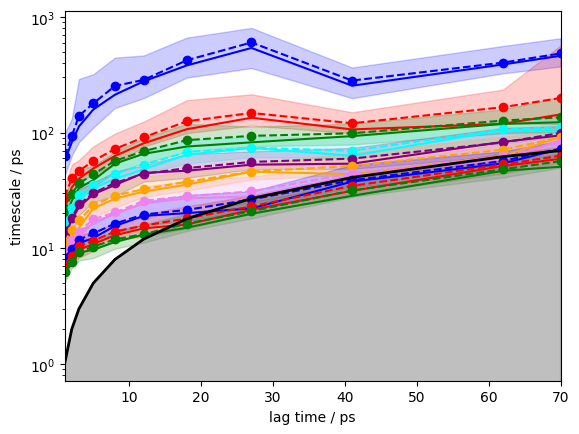

In [21]:
its = pyemma.msm.its(cluster.dtrajs, lags=70, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ps', dt=1 )

 Implied timescales represent the relaxation timescales of the slowest processes in the system that the MSM captures.

 The lines that are above the gray shaded area are the processes within the ITS, because they are slower than the lag time. The other ones are faster processes therefore can not be resolved.

 As MSMs tend to underestimate the true ITSs, we are looking for a converged maximum in the ITS plot. In our case, any lag time before the slow process (blue line) crosses the lag time threshold (black line) would work. To maximize the kinetic resolution, we choose the lag time 1
 step.

To see whether our model satisfies Markovianity, we perform (and visualize) a Chapman-Kolmogorow (CK) test. Since we aim at modeling the dynamics between metastable states rather than between microstates, this will be conducted in the space of metastable states. The latter are identified automatically using PCCA++. We usually choose the number of metastable states according to the implied timescales plot by identifying a gap between the ITS.

We observe 4 resolved processes at approximately 10 ps timescale. And we can also see that the ITS is converging.

In [68]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=1, dt_traj='0.1 ps')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[22]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

fraction of states used = 0.89
fraction of counts used = 0.92


##Chapman-Kolmogorov test

The model is validated with a Chapman-Kolmogorov test. It compares the right and the left side of the Chapman-Kolmogorov equation

T(kτ)=Tk(τ)
with T
 being the transition matrix. PyEMMA automatically estimates a new MSM transition matrix at lag time kτ
 and propagates the original transition matrix by the k
-th power. The highest k
 can be adjusted using the mlags keyword argument of msm.cktest().

We select nstates = 6 becuase from clusterization we obtained more or less 6 discrete states

estimating BayesianMSM:   0%|          | 0/5 [00:00<?, ?it/s]

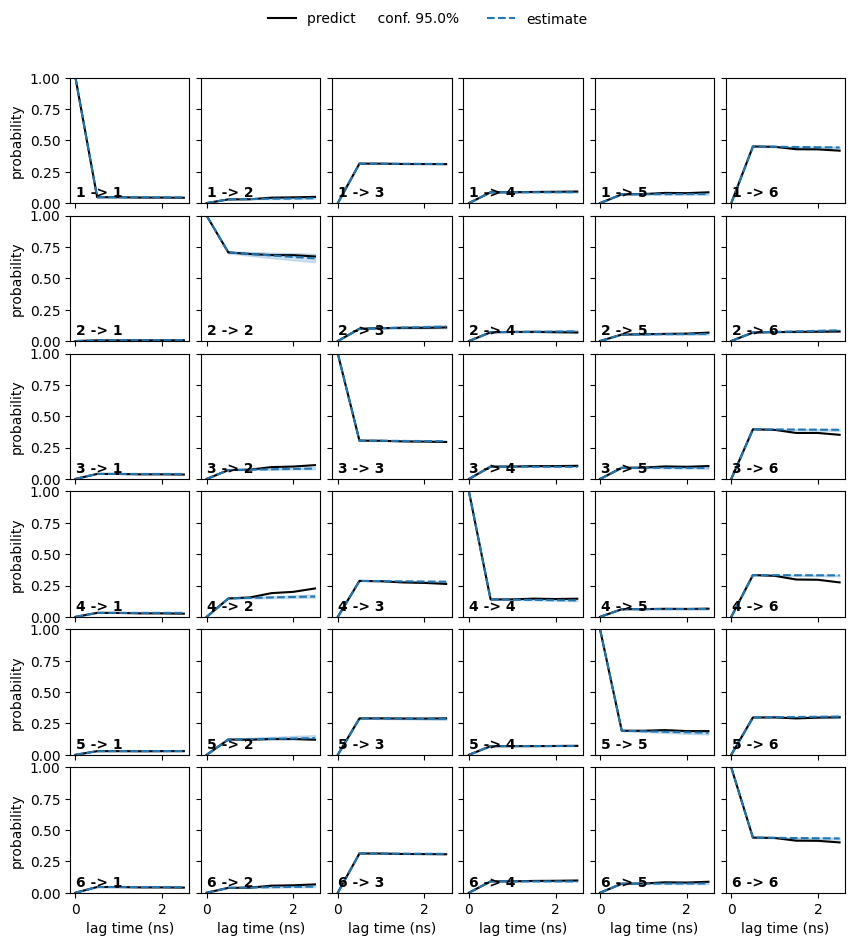

In [137]:
nstates = 6
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

We can see that there is not too much deviation between the estimate and the prediction. Therefore we can say that we have a good working model.

Time Lagged Correlation: The Chapman-Kolmogorov test helps assess the validity of the Markov assumption at different lag times. It examines whether the probability distributions of observed transitions match the distributions predicted by the Markov model at each lag time.

Interpreting the Plots: The plot generated by plot_cktest typically shows the normalized root mean square deviation (NRMSD) between the estimated transition probabilities at each lag time and those predicted by the model. Lower NRMSD values indicate better agreement between the observed and predicted transition probabilities.

Significance of Deviations: Large deviations between the observed and predicted transition probabilities may indicate violations of the Markov assumption or inaccuracies in the model. These deviations could result from insufficient sampling, model complexity, or limitations in the underlying assumptions.

Higher Transition Probabilities: If you observe that certain transitions have higher probabilities compared to others, it suggests that these transitions are more likely to occur within the system. This information can provide insights into the dynamics and kinetics of the system under study.

In summary, the plots generated by the Chapman-Kolmogorov test help assess the agreement between observed and predicted transition probabilities in a Markov state model. They provide insights into the dynamics and kinetics of the system under study and help evaluate the validity of the underlying assumptions.

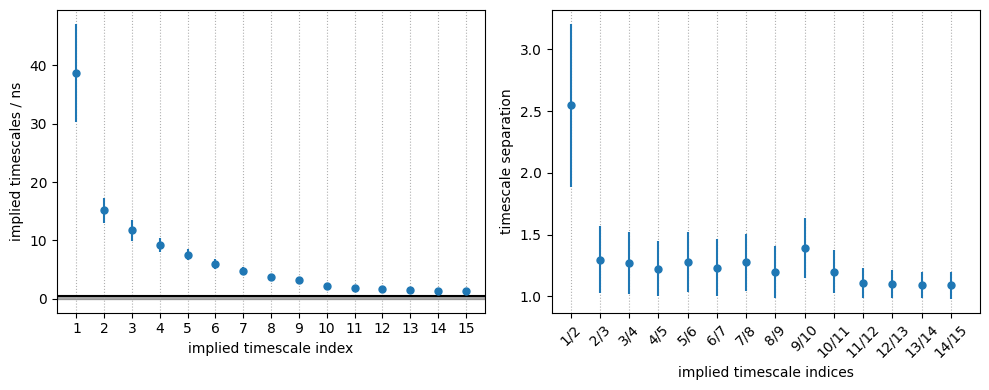

In [95]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits)],  # Adjusted range
    rotation=45
)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

Separation of Timescales: The separation of timescales refers to the difference in magnitude between consecutive implied timescales. In other words, it measures the relative rates at which different dynamical processes occur within the system.

Interpretation: Large separation between consecutive timescales indicates that there is a significant difference in the rates of the corresponding processes. For example, if the separation between the first and second timescales is large, it suggests that the first process occurs much more slowly compared to the second process.

Significance: Timescale separation is crucial for understanding the hierarchy of dynamical processes within the system. It helps identify the dominant processes governing the system's behavior and provides insights into the complexity of the dynamics.

Error in Timescale Separation: Since implied timescales are estimated from data, there can be uncertainties associated with their values. The error in timescale separatio quantifies the uncertainty in the separation between consecutive timescales due to the error propagation from the standard deviation of the implied timescales.

In [69]:
print(msm.active_set)

[ 0  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 25 26
 27]


In [70]:
print(msm.stationary_distribution)
print('sum of weights = {:f}'.format(msm.pi.sum()))

[0.01332242 0.02973713 0.07942951 0.04432848 0.05641633 0.03403806
 0.02963481 0.05449444 0.04357382 0.08275073 0.00910862 0.04103581
 0.0387981  0.04307907 0.0214578  0.01233882 0.07464262 0.03001673
 0.02252713 0.03452498 0.10934281 0.018162   0.03281598 0.02439481
 0.02002897]
sum of weights = 1.000000


In [96]:
len(msm.pi)

25

In [72]:
data = tica_concatenated
np.shape(data)

(2598, 10)

In [73]:
len(cluster.dtrajs[0])

101

In [109]:
# Assuming msm.pi has 25 elements and you want to interpolate to get values for 101 states
x = np.arange(len(msm.pi))  # Indices of known msm.pi values
y = msm.pi  # Known stationary distribution values

# Define the interpolation function
f = interpolate.interp1d(x, y, kind='linear')

# Interpolate to get values for 101 states
new_x = np.linspace(0, len(msm.pi) - 1, len(cluster.dtrajs[0]))  # Indices for 101 states
msm_pi = f(new_x)  # Interpolated values

# Calculate vmin and vmax based on the range of values in msm_pi
vmin = np.min(msm_pi)
vmax = np.max(msm_pi)

fig, ax, misc = pyemma.plots.plot_contour(
    *data.T, msm_pi[cluster.dtrajs[0]],
    cbar_label='stationary distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

IndexError: index 27 is out of bounds for axis 0 with size 25

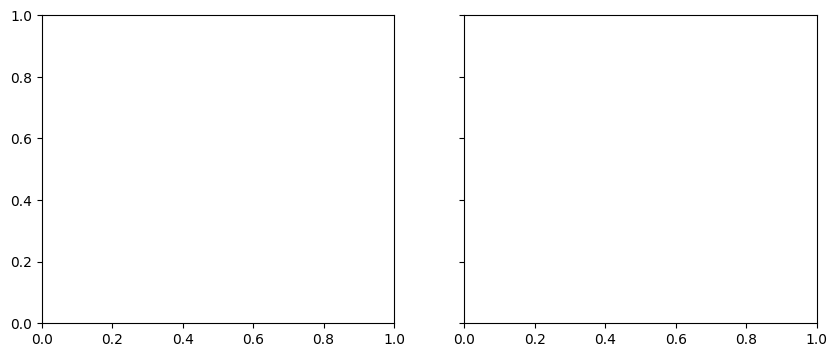

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()


After here are additional things

In [97]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
print("data len:",len(data))
print("data shape:",np.shape(data))
data_concatenated = np.concatenate(data)
print("data_concat len:",len(data_concatenated))
print("data_concat shape:", np.shape(data_concatenated))
# Check the number of dimensions in the data
num_dimensions = data_concatenated.shape[1]
print("num dimensions",num_dimensions)

# Define feature labels corresponding to each dimension
feature_labels = ['$\Phi$', '$\Psi$'] * (num_dimensions // 2)


# Ensure that the length of feature_labels matches the number of dimensions
if len(feature_labels) != num_dimensions:
    # Adjust the feature labels to match the number of dimensions
    feature_labels = ['$\Phi$', '$\Psi$'] * num_dimensions
print("Len feature labels", len(feature_labels))


Obtaining file info:   0%|          | 0/8 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/8 [00:00<?, ?it/s]

data len: 8


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.

initialize kmeans++ centers:   0%|          | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

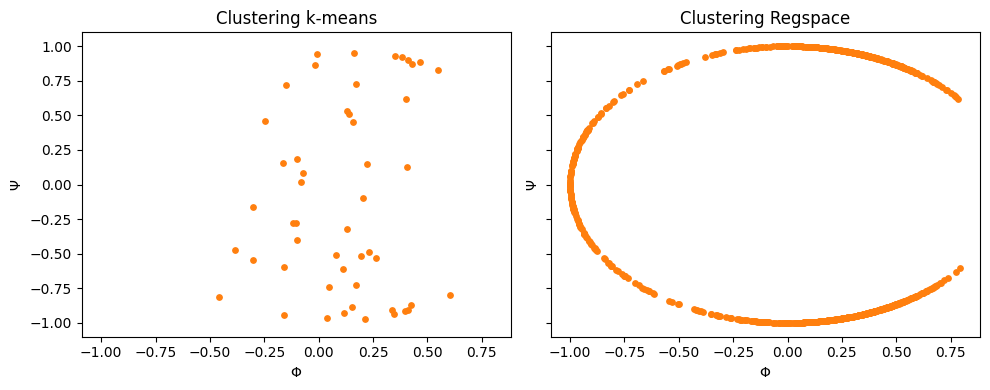

In [85]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=50, max_iter=50, stride=5)
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.3)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, cls, title in zip(axes.flat, [cluster_kmeans, cluster_regspace], ["Clustering k-means", "Clustering Regspace"]):
    pyemma.plots.plot_density(cls.clustercenters[:, 0], cls.clustercenters[:, 1], ax=ax, cbar=False, alpha=0.1, logscale=True)
    ax.scatter(cls.clustercenters[:, 0], cls.clustercenters[:, 1], s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
    ax.set_title(title)
fig.tight_layout()


NameError: name 'data_concatenated' is not defined

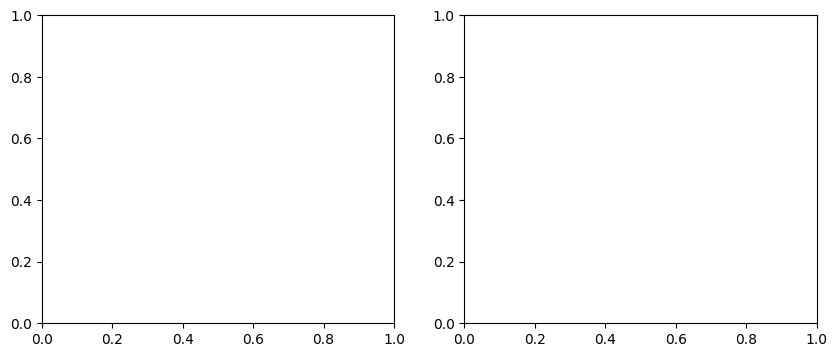

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    pyemma.plots.plot_density(*data_concatenated.T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cls.clustercenters.T, s=15, c='C1')
    ax.set_xlabel('$x$')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
axes[0].set_ylabel('$y$')
fig.tight_layout()

getting output of KmeansClustering:   0%|          | 0/4 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

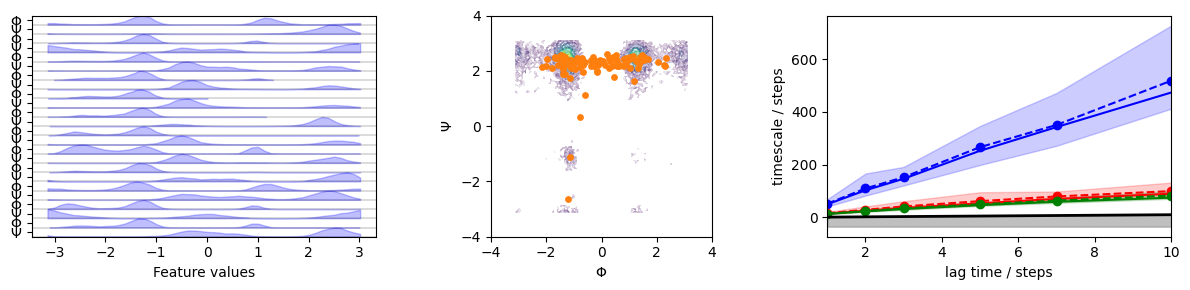

In [ ]:
cluster = cluster_kmeans
its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')

# Plot feature histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feature_labels, ax=axes[0])
pyemma.plots.plot_density(data_concatenated[:, 0], data_concatenated[:, 1], ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(cluster.clustercenters[:, 0], cluster.clustercenters[:, 1], s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=axes[2])
fig.tight_layout()


In [ ]:
num_samples, num_features = np.shape(data_concatenated)
num_features_phi = num_features // 2
num_features_psi = num_features - num_features_phi

# Create arrays to store phi and psi data
phi = data_concatenated[:, ::2]  # Select every other column starting from the first (index 0)
psi = data_concatenated[:, 1::2]  # Select every other column starting from the second (index 1)

# Ensure the shapes of phi and psi are as expected
assert phi.shape == (num_samples, num_features_phi)
assert psi.shape == (num_samples, num_features_psi)
all_phi = phi.flatten()
all_psi = psi.flatten()


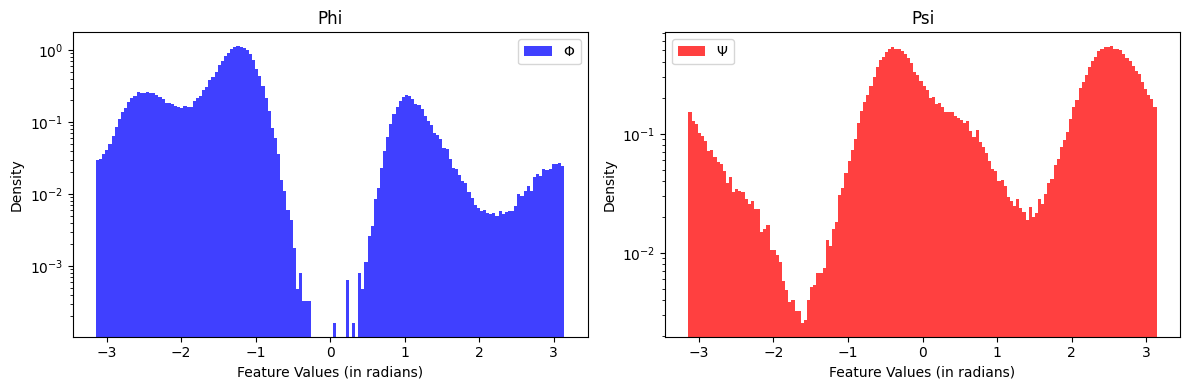

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(all_phi, bins=150, density=True, alpha=0.75, color='blue', label='$\Phi$')
axes[1].hist(all_psi, bins=150, density=True, alpha=0.75, color='red', label='$\Psi$')

axes[0].set_xlabel('Feature Values (in radians)')
axes[0].set_ylabel('Density')
axes[1].set_xlabel('Feature Values (in radians)')
axes[1].set_ylabel('Density')
axes[0].set_title('Phi')
axes[1].set_title('Psi')
axes[0].legend()
axes[1].legend()

# Set y-axis scale to logarithmic
axes[0].set_yscale('log')
axes[1].set_yscale('log')

fig.tight_layout()
plt.show()


Regspace seems to make better clusters. But the kmeans lag times look better. Maybe another clustering algorithm should be implemented

In [ ]:
msm.pi

array([4.72297588e-04, 3.77940732e-05, 3.40132836e-03, 8.10323412e-02,
       5.77069711e-02, 1.61040387e-04, 5.48804703e-04, 5.12033713e-04,
       1.61594891e-04, 1.56467962e-03, 2.73515629e-04, 6.75231804e-04,
       2.54522394e-04, 2.53891143e-04, 1.28463865e-03, 4.43252505e-04,
       5.07261995e-05, 7.15723334e-02, 3.61118949e-04, 4.64637633e-04,
       2.42991198e-04, 3.04452849e-04, 5.80887635e-04, 2.33668223e-04,
       5.34605227e-03, 2.96394556e-04, 1.32439862e-04, 4.24814165e-04,
       1.27304712e-04, 2.04920715e-01, 5.61444434e-04, 4.92937450e-01,
       3.25242559e-04, 4.03771331e-04, 2.24092591e-04, 4.05731651e-04,
       3.19548471e-04, 6.57075315e-04, 9.61070136e-04, 2.15146476e-04,
       2.21768046e-04, 5.02932116e-04, 6.09725505e-04, 3.64077578e-04,
       2.53945719e-04, 4.32253819e-04, 1.41234046e-03, 2.45806958e-02,
       2.08832804e-04, 1.59605349e-04, 2.89336945e-04, 1.09122376e-04,
       3.02753727e-04, 3.74121864e-02, 2.26474760e-04, 2.18288386e-04,
      

In [ ]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [ ]:
msm.pcca(nstates)


In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()


In [297]:
pca = pyemma.coordinates.pca(data, dim=10)
pca_output = pca.get_output()
tica = pyemma.coordinates.tica(data, dim=10, lag=best_lag)
tica_output = tica.get_output()
vamp = pyemma.coordinates.vamp(data, dim=10, lag=best_lag)
vamp_output = vamp.get_output()

# Concatenate the PCA, TICA, and VAMP feature values
pca_concatenated = np.concatenate(pca_output)
tica_concatenated = np.concatenate(tica_output)
vamp_concatenated = np.concatenate(vamp_output)

# Generate feature labels based on the number of dimensions
num_dimensions = pca_concatenated.shape[1] + tica_concatenated.shape[1] + vamp_concatenated.shape[1]
feature_labels = ['PCA', 'TICA', 'VAMP'] * (num_dimensions // 3)


This part is just for testing

In [298]:
pdb_1 = '/content/lb6-filtered.pdb'
files_1 ='/content/lb6-filtered.xtc'
# Load the trajectory
traj_data = pyemma.coordinates.load(files_1, top = pdb_1)


In [299]:
#pdb_1= mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
#files_1 = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

#files_1 = ['lb6-filtered_01.lammpstrj','lb6-filtered_02.lammpstrj','lb6-filtered_12.lammpstrj']
torsions_feat_1 = pyemma.coordinates.featurizer(pdb_1)
torsions_feat_1.add_backbone_torsions(cossin=True, periodic=False)
torsions_data_1 = pyemma.coordinates.load(files_1, features=torsions_feat_1)
labels_1 = ['backbone\ntorsions']

positions_feat_1 = pyemma.coordinates.featurizer(pdb_1)
positions_feat_1.add_selection(positions_feat_1.select_Backbone())
positions_data_1 = pyemma.coordinates.load(files_1, features=positions_feat_1)
labels_1 += ['backbone atom\npositions']

distances_feat_1 = pyemma.coordinates.featurizer(pdb_1)
distances_feat_1.add_distances(
    distances_feat_1.pairs(distances_feat_1.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data_1 = pyemma.coordinates.load(files_1, features=distances_feat_1)
labels_1 += ['backbone atom\ndistances']

In [300]:
data = traj_data


In [301]:
cluster = pyemma.coordinates.cluster_kmeans(data, k=50, max_iter=500)
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.5)

initialize kmeans++ centers:   0%|          | 0/50 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/500 [00:00<?, ?it/s]

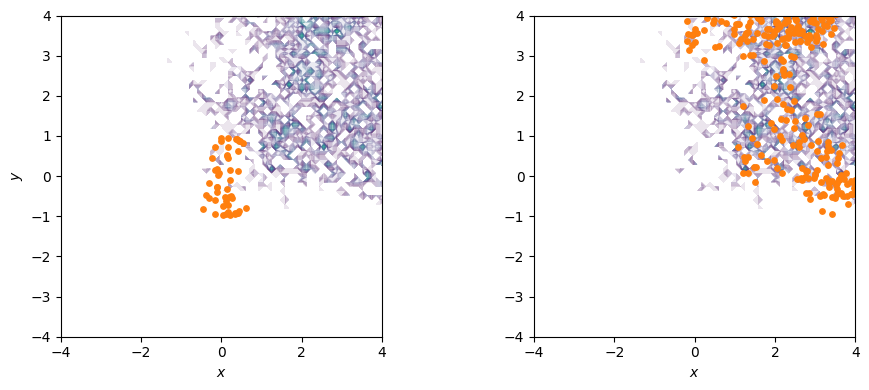

In [302]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot density for each cluster
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    pyemma.plots.plot_density(data[:, 0], data[:, 1], ax=ax, cbar=False, alpha=0.1)  # Pass data as a tuple
    ax.scatter(cls.clustercenters[:, 0], cls.clustercenters[:, 1], s=15, c='C1')  # Correct scatter call
    ax.set_xlabel('$x$')
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')

axes[0].set_ylabel('$y$')
fig.tight_layout()

Therefore, the orange dots represent the cluster centers obtained from the k-means clustering algorithm, while the purple dots represent the cluster centers obtained from the regular space clustering algorithm. These cluster centers provide insights into the grouping of data points achieved by each clustering algorithm in the two-dimensional space defined by the features 'x' and 'y'.

For each trajectory passed to the clustering object, we get a corresponding discrete trajectory.

In [303]:
#print(cluster_kmeans.dtrajs)
#print(cluster_regspace.dtrajs)

In [308]:
pca = pyemma.coordinates.pca(data, dim=2)
pca_output = pca.get_output()
tica = pyemma.coordinates.tica(data, dim=1, lag=2)
tica_output = tica.get_output()
vamp = pyemma.coordinates.vamp(data, dim=1, lag=2)
vamp_output = vamp.get_output()



In [309]:
np.shape(tica)

()

In [310]:
np.shape(tica_output)

(1, 10836, 1)

ValueError: feature_labels must have the same dimension as the input data xyzall.

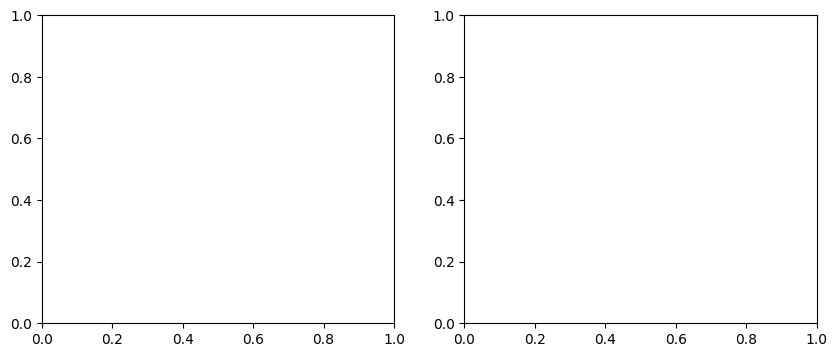

In [311]:
# Unpack the outputs of PCA, TICA, and VAMP transformations
pca_concatenated = pca_output[0]
tica_concatenated = tica_output[0]
vamp_concatenated = vamp_output[0]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot feature histograms
pyemma.plots.plot_feature_histograms(
    np.concatenate([pca_concatenated, tica_concatenated, vamp_concatenated], axis=1),
    feature_labels=['PCA', 'TICA', 'VAMP'],
    ax=axes[0])

# Plot density
pyemma.plots.plot_density(data[:, 0], data[:, 1], ax=axes[1], cbar=False, alpha=0.1)
axes[1].plot(
    [0, 3 * pca.eigenvectors[0, 0]],
    [0, 3 * pca.eigenvectors[1, 0]],
    linewidth=3,
    label='PCA')
axes[1].plot(
    [0, 3 * tica.eigenvectors[0, 0]],
    [0, 3 * tica.eigenvectors[1, 0]],
    linewidth=3,
    label='TICA')
axes[1].plot(
    [0, 3 * vamp.singular_vectors_right[0, 0]],
    [0, 3 * vamp.singular_vectors_right[1, 0]],
    linewidth=3,
    label='VAMP')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
axes[1].legend()
fig.tight_layout()

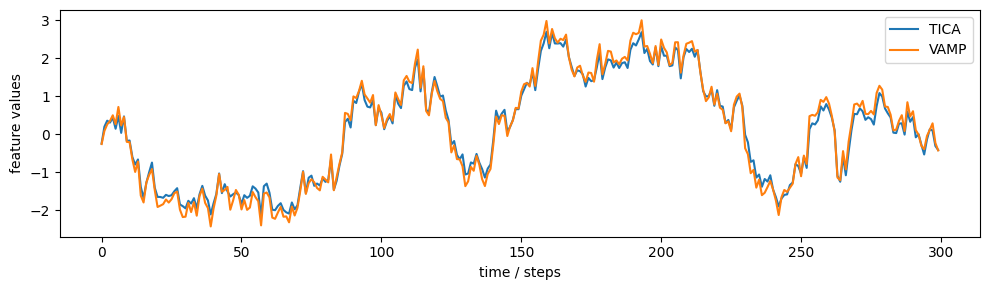

In [188]:
fig, ax = plt.subplots(figsize=(10, 3))
#ax.plot(pca_concatenated[:300], label='PCA')
ax.plot(tica_concatenated[:300], label='TICA')
# note that for better comparability, we enforce the same direction as TICA
ax.plot(vamp_concatenated[:300] * -1, label='VAMP')
ax.set_xlabel('time / steps')
ax.set_ylabel('feature values')
ax.legend()
fig.tight_layout()


Min value: 0.03450750108041374
Max value: 0.3718877297330049


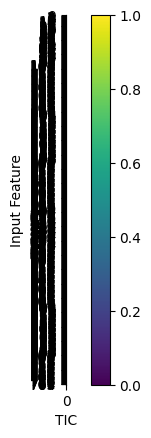

In [196]:
# Check the range of values in the feature-TIC correlation matrix
print("Min value:", feature_TIC_correlation.min())
print("Max value:", feature_TIC_correlation.max())

# Create the plot
fig, ax = plt.subplots()
# Ensure that the matrix contains meaningful data
if feature_TIC_correlation is not None:
    # Define a sequential colormap for positive correlations
    cmap = 'viridis'
    # Normalize the color mapping using a fixed range to enhance visibility
    norm = Normalize(vmin=0, vmax=1)  # Assuming correlations range from 0 to 1

    # Plot the feature-TIC correlation matrix
    i = ax.imshow(feature_TIC_correlation, cmap=cmap, norm=norm)

    ax.set_xticks(range(feature_TIC_correlation.shape[1]))
    ax.set_xlabel('TIC')

    ax.set_yticks(range(feature_TIC_correlation.shape[0]))
    ax.set_ylabel('Input Feature')

    fig.colorbar(i, ax=ax)
else:
    print("Feature-TIC correlation matrix is empty or None.")

plt.show()

In [214]:
files

['/content/traj_files/02_strd.lammpstrj',
 '/content/traj_files/lb6-filtered_29ns.lammpstrj',
 '/content/traj_files/36_01_strd.lammpstrj',
 '/content/traj_files/lb6-filtered.lammpstrj',
 '/content/traj_files/20_strd.lammpstrj']

In [215]:
feat = pyemma.coordinates.featurizer(pdb_1)
feat.add_backbone_torsions(cossin=True, periodic=False)
#feat.add_sidechain_torsions(which='all', cossin=True, periodic=False)
#feat.add_sidechain_torsions(which=('arg', 'asn', 'asp', 'glu', 'his', 'lys', 'gln'), cossin=True, periodic=False)



train_files = files[:-2]
test_file = files[-2]  # last trajectory is our test data set
assert set(train_files) & set(test_file) == set()  # ensure test and train sets do not overlap

data_torsions = pyemma.coordinates.load(train_files, features=feat)
data_torsions_test = pyemma.coordinates.load(test_file, features=feat)

feat.active_features = []
feat.add_distances_ca(periodic=False)

data_dists_ca = pyemma.coordinates.load(train_files, features=feat)
data_dists_ca_test = pyemma.coordinates.load(test_file, features=feat)

feat.active_features = []
pairs = feat.pairs(feat.select_Heavy())
feat.add_contacts(pairs, periodic=False)

data_contacts = pyemma.coordinates.load(train_files, features=feat)
data_contacts_test = pyemma.coordinates.load(test_file, features=feat)

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

In [216]:
data_concatenated = data_torsions + [data_torsions_test] # concatenate two lists

list

calc mean+cov:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/4 [00:00<?, ?it/s]

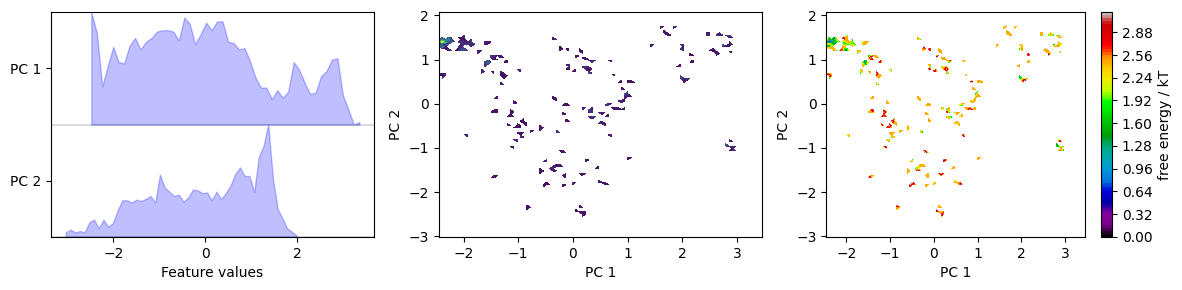

In [217]:
pca = pyemma.coordinates.pca(data_concatenated, dim=2)
pca_concatenated = np.concatenate(pca.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    pca_concatenated,
    ['PC {}'.format(i + 1) for i in range(pca.dimension())],
    ax=axes[0])
pyemma.plots.plot_density(*pca_concatenated[:, :2].T, ax=axes[1], cbar=False)
pyemma.plots.plot_free_energy(*pca_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

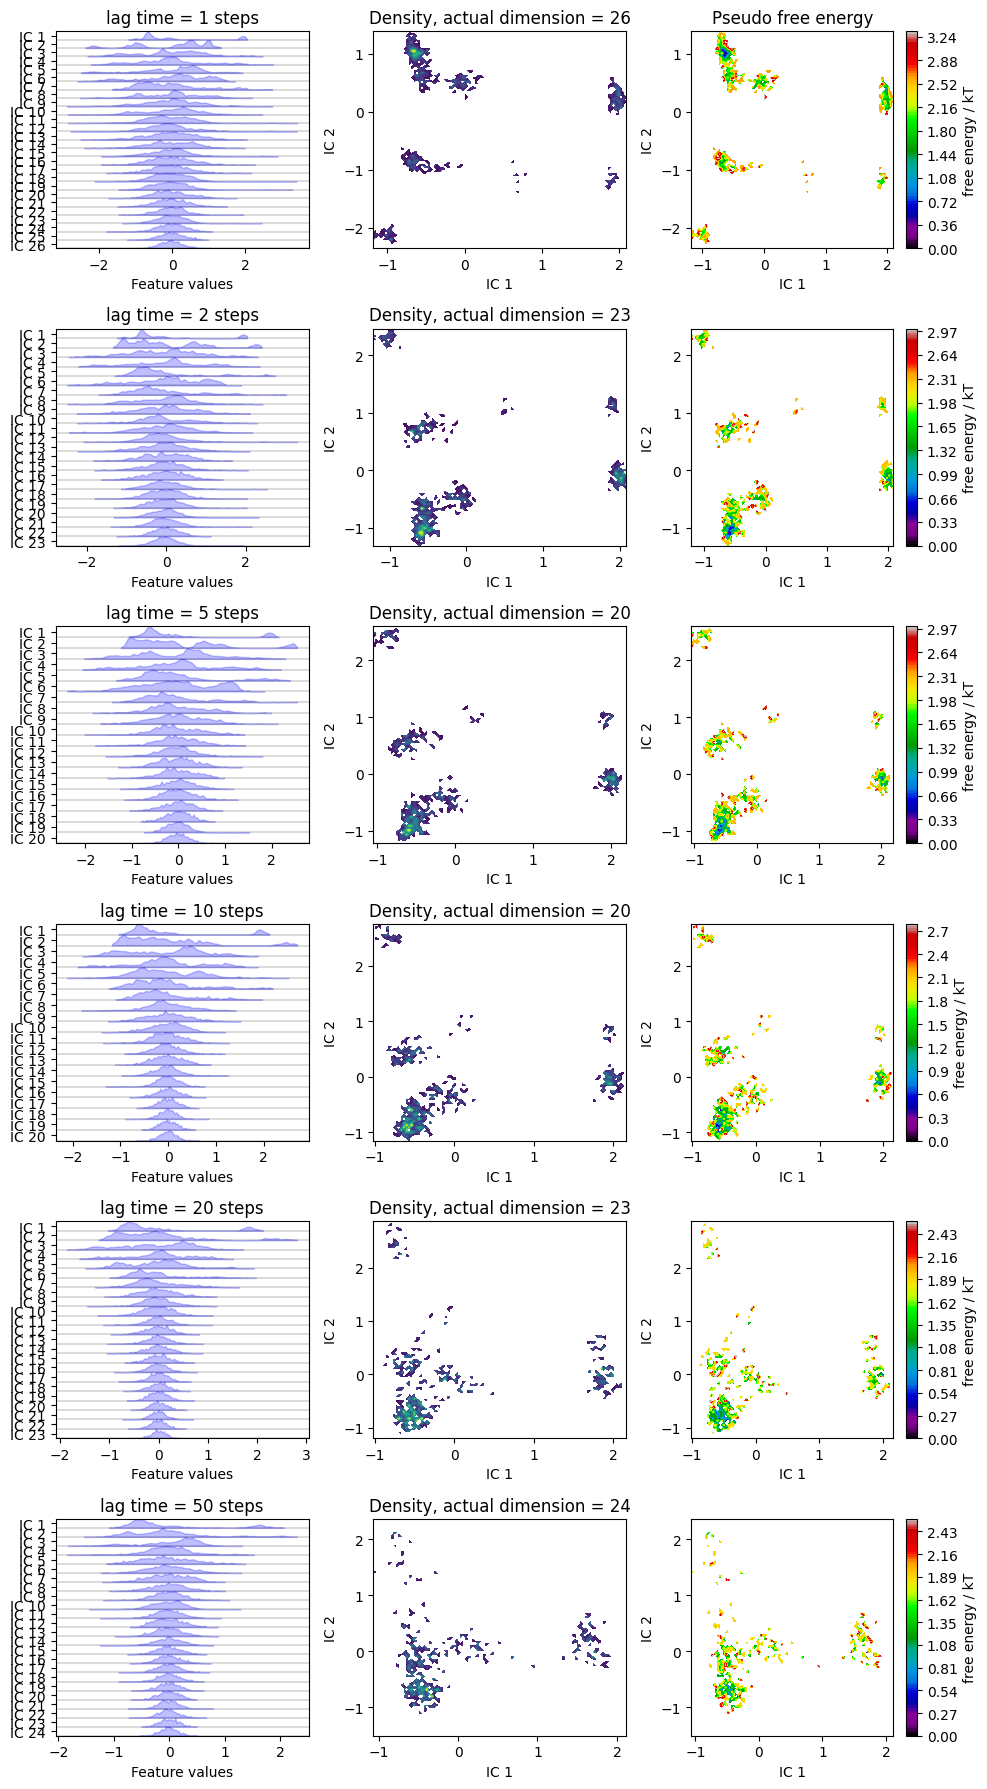

In [218]:
lags = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(6, 3, figsize=(10, 18))
for i, lag in enumerate(lags):
    tica = pyemma.coordinates.tica(data_concatenated, lag=lag)
    tica_concatenated = np.concatenate(tica.get_output())
    pyemma.plots.plot_feature_histograms(
        tica_concatenated,
        ['IC {}'.format(i + 1) for i in range(tica.dimension())],
        ax=axes[i, 0])
    axes[i, 0].set_title('lag time = {} steps'.format(lag))
    axes[i, 1].set_title(
        'Density, actual dimension = {}'.format(tica.dimension()))
    pyemma.plots.plot_density(
        *tica_concatenated[:, :2].T, ax=axes[i, 1], cbar=False)
    pyemma.plots.plot_free_energy(
        *tica_concatenated[:, :2].T, ax=axes[i, 2], legacy=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
axes[0, 2].set_title('Pseudo free energy')
fig.tight_layout()

calc mean+cov:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/4 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

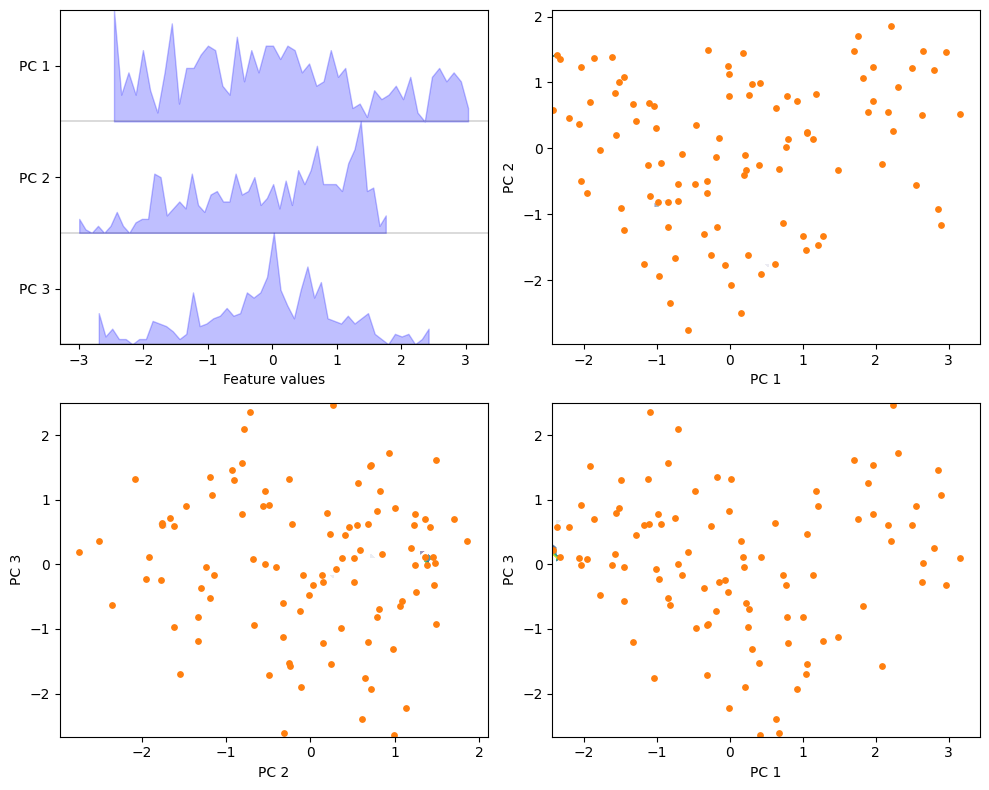

In [219]:
pca = pyemma.coordinates.pca(data_concatenated, dim=3)
pca_concatenated = np.concatenate(pca.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(pca, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    pca_concatenated, ['PC {}'.format(i + 1) for i in range(pca.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(*pca_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('PC {}'.format(i + 1))
    ax.set_ylabel('PC {}'.format(j + 1))
fig.tight_layout()

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

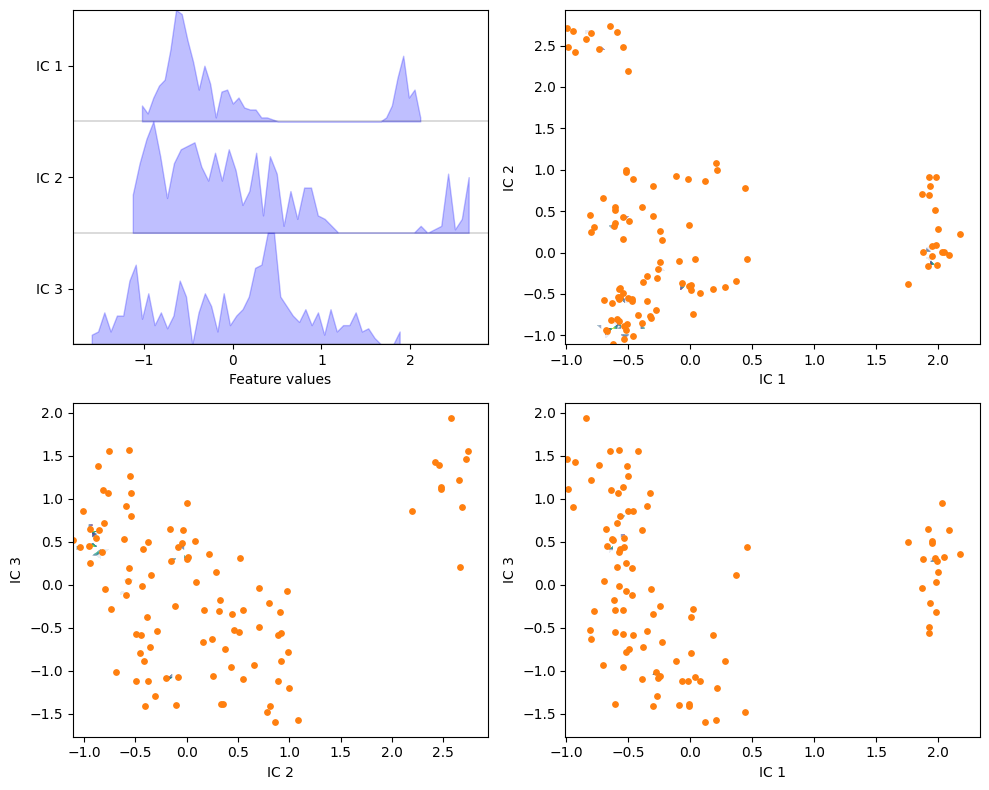

In [312]:
tica = pyemma.coordinates.tica(data_concatenated, dim=3)
tica_concatenated = np.concatenate(tica.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *tica_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of VAMP:   0%|          | 0/4 [00:00<?, ?it/s]

initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

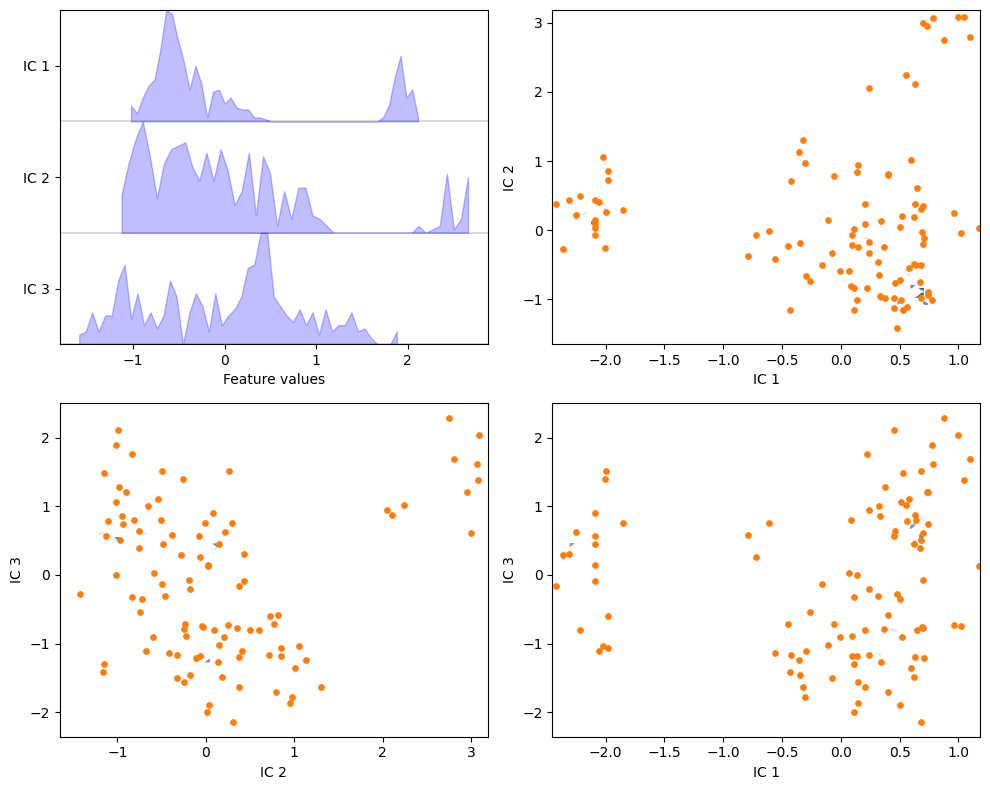

In [221]:
vamp = pyemma.coordinates.vamp(data_concatenated, lag=20, dim=3)
vamp_concatenated = np.concatenate(vamp.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(vamp, k=100, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(*vamp_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15, c='C1')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
fig.tight_layout()

In [223]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')

getting output of KmeansClustering:   0%|          | 0/4 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

estimating MaximumLikelihoodMSM:   0%|          | 0/9 [00:00<?, ?it/s]

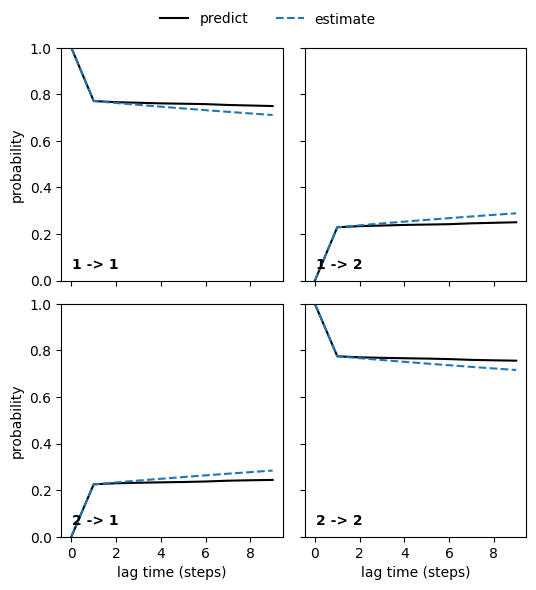

In [224]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1)
pyemma.plots.plot_cktest(msm.cktest(2));

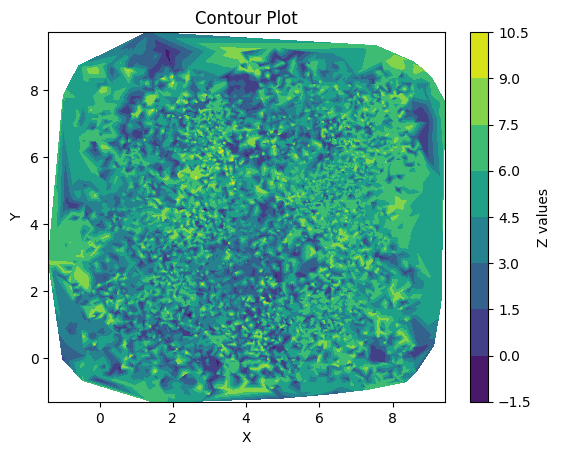

In [236]:
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Create the contour plot
fig, ax = plt.subplots()
contour = ax.tricontourf(x, y, z, cmap='viridis')  # Adjust cmap as needed

# Add colorbar
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Z values')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Contour Plot')

# Show the plot
plt.show()


In [327]:
tica = pyemma.coordinates.tica(data_concatenated, dim=3)
tica_concatenated = np.concatenate(tica.get_output(stride=5))


calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

In [328]:
np.shape(tica_concatenated)

(516, 3)

In [341]:
weights = msm.pi[cluster.dtrajs[0]]

data_1 = tica.eigenvectors.T

IndexError: index 77 is out of bounds for axis 0 with size 73

In [342]:
np.shape(data_tica)

(48, 2)

In [343]:
import pyemma

# Assuming data_1 is your input data
# Perform TICA to reduce dimensionality
tica = pyemma.coordinates.tica(data_1, lag=1, dim=2)
tica_output = tica.get_output()

# Get the transformed data
data_tica = tica_output[0]
# Plot the free energy surface
fig, ax = pyemma.plots.plot_free_energy(
    data_tica[:, 0], data_tica[:, 1],  # Assuming you want to plot the first two dimensions
    weights=weights
)

# Set labels and limits
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()


ValueError: object of too small depth for desired array

ValueError: not enough values to unpack (expected 3, got 2)

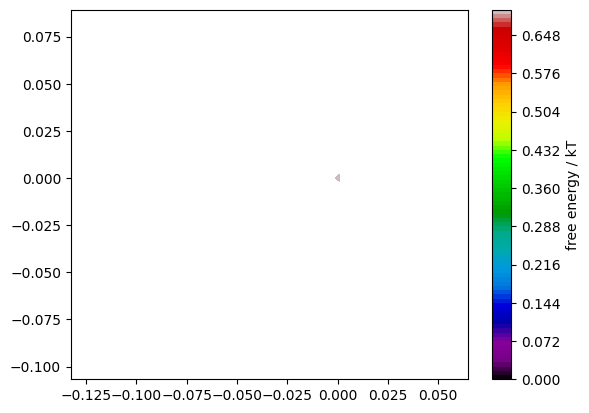

In [332]:
fig, ax, misc = pyemma.plots.plot_free_energy(
    data_1[:, 0], data_1[:, 1],  # Provide X and Y coordinates separately
    weight=weights)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
fig.tight_layout()


In [ ]:
def compare_files(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        # Read the contents of the files
        content1 = f1.read()
        content2 = f2.read()

        # Compare the contents
        if content1 == content2:
            print("The contents of the files are the same.")
        else:
            print("The contents of the files are different.")

# Specify the paths to the lammpstrj files
file1_path = files_1[0]
file2_path = files_1[2]

# Call the function to compare the files
compare_files(file1_path, file2_path)


In [ ]:
dim = 2

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10]):
    torsions_scores_1 = score_cv(torsions_data_1, lag=lag, dim=dim)
    scores_1 = [torsions_scores_1.mean()]
    errors_1 = [torsions_scores_1.std()]
    positions_scores_1 = score_cv(positions_data_1, lag=lag, dim=dim)
    scores_1 += [positions_scores_1.mean()]
    errors_1 += [positions_scores_1.std()]
    distances_scores_1 = score_cv(distances_data_1, lag=lag, dim=dim)
    scores_1 += [distances_scores_1.mean()]
    errors_1 += [distances_scores_1.std()]
    ax.bar(labels_1, scores_1, yerr=errors_1, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot_1 = dict(
            labels=labels_1, scores=scores_1, errors=errors_1, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()


In [ ]:
lags = [1, 2, 5, 10, 20]
dims_1 = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_1 = np.array([score_cv(torsions_data_1, dim, lag)
                        for dim in dims_1])
    scores_1 = np.mean(scores_1, axis=1)
    errors_1 = np.std(scores_1, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims_1, scores_1 - errors_1, scores_1 + errors_1, alpha=0.3, facecolor=color)
    ax.plot(dims_1, scores_1, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()


In [ ]:
pyemma.plots.plot_feature_histograms(files, feature_labels=['$x$', '$y$']);

In [ ]:
warnings.resetwarnings()
#widgets don't work on google colab

In [ ]:
# Create an NGLview widget to display the PDB file - should tis display here? cuz it's not doing it
view = nglview.show_file(pdb)
#view.add_representation('cartoon')
#view.center()
#view

view = nglview.NGLWidget()
view.add_pdbid(pdb)
view.add_representation('cartoon')
view.center()
view

# 2nd cell
view._js("console.log(this.model.views)")

In [ ]:
traj = mdtraj.load(pdb)

# Create the widget
widget = nglview.show_mdtraj(traj)
widget.add_ball_and_stick()

# Display the widget
display(widget)

# Define a function to stop spinning and close the widget
def stop_spin():
    widget.player.spin = False
    widget.close()

# Set a timer to stop spinning and close the widget after 30 seconds
Timer(30, stop_spin).start()


In [ ]:
# # Parse the PDB file using BioPython's PDBParser
# parser = PDBParser()
# structure = parser.get_structure('my_structure', '/content/lb6-filtered.pdb')

# # Prepare coordinates for PyEmma
# coordinates = []
# for model in structure:
#     for chain in model:
#         for residue in chain:
#             for atom in residue:
#                 coordinates.append(atom.get_coord())

# # Convert coordinates to PyEmma's format (assuming 3D coordinates)
# coordinates = [list(atom_coord) for atom_coord in coordinates]


# # Perform PyEmma analysis (example: PCA)
# #pca = pyemma.coordinates.pca(coordinates)


In [ ]:
# # Define the file path for saving the coordinates
# txt_file = '/content/coordinates.txt'


# # Write coordinates to a text file
# with open(txt_file, 'w') as file:
#     for coord in coordinates:
#         file.write(','.join(map(str, coord)) + '\n')
